### Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [11]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Python Projects/Melanoma Assignment/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Python Projects/Melanoma Assignment/Test")

In [19]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Training Image Count:-",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Testing Image Count:-",image_count_test)

Training Image Count:- 2239
Testing Image Count:- 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [20]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [21]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [22]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [23]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names

for Names in class_names:
  print(Names)

actinic keratosis
basal cell carcinoma
dermatofibroma
melanoma
nevus
pigmented benign keratosis
seborrheic keratosis
squamous cell carcinoma
vascular lesion


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

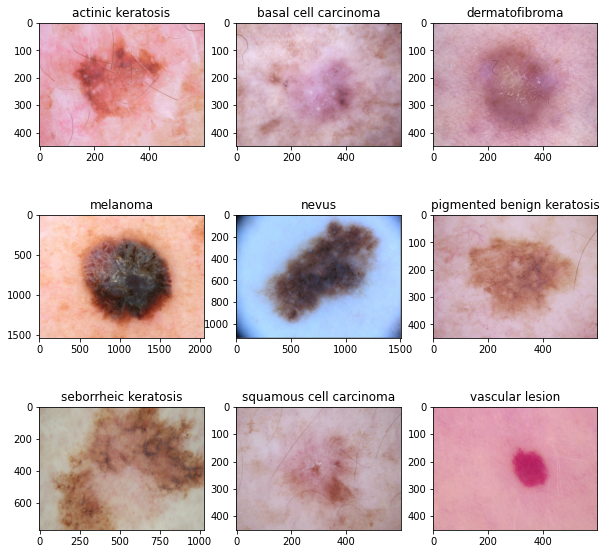

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [26]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))



model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [27]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [29]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 275s 1s/step - loss: 2.0549 - accuracy: 0.1981 - val_loss: 2.0866 - val_accuracy: 0.1879
Epoch 2/20
56/56 [==============================] - 4s 77ms/step - loss: 1.9668 - accuracy: 0.2372 - val_loss: 1.8805 - val_accuracy: 0.3177
Epoch 3/20
56/56 [==============================] - 4s 77ms/step - loss: 1.9888 - accuracy: 0.2511 - val_loss: 2.0764 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 4s 77ms/step - loss: 2.0435 - accuracy: 0.2059 - val_loss: 2.0360 - val_accuracy: 0.1924
Epoch 5/20
56/56 [==============================] - 4s 77ms/step - loss: 2.0207 - accuracy: 0.1964 - val_loss: 2.0545 - val_accuracy: 0.2013
Epoch 6/20
56/56 [==============================] - 4s 76ms/step - loss: 2.0162 - accuracy: 0.1908 - val_loss: 2.0320 - val_accuracy: 0.1924
Epoch 7/20
56/56 [==============================] - 4s 77ms/step - loss: 1.9442 - accuracy: 0.2589 - val_loss: 1.9352 - val_accuracy: 0.2908
Epoch 8/20
56/56 [======

### Visualizing training results

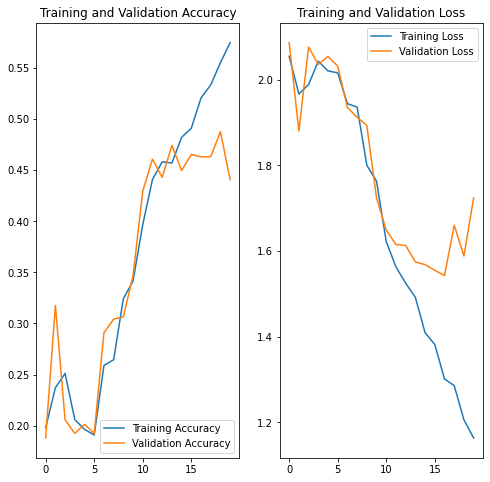

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observaations-
- The accuracy of both training and validation are going hand in hand between epochs 10-15.
- But after that, the validation accuracy has decreased substantially.
- Also, there is an sharp increase in the validation error after steep decrease. 

In [31]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

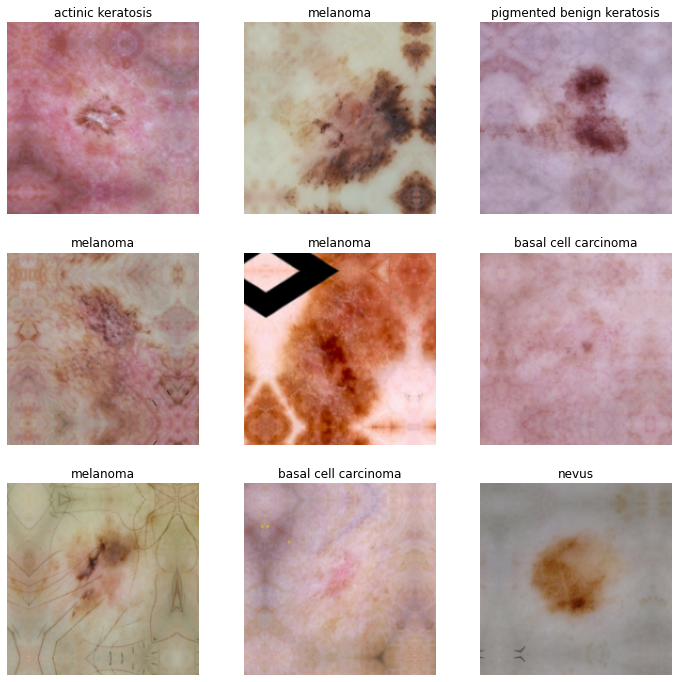

In [32]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create the model, compile and train the model


In [33]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.30))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))



### Compiling the model

In [34]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [35]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 7s 91ms/step - loss: 2.1063 - accuracy: 0.1808 - val_loss: 2.1527 - val_accuracy: 0.1969
Epoch 2/20
56/56 [==============================] - 5s 87ms/step - loss: 2.0832 - accuracy: 0.2154 - val_loss: 2.0435 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 5s 86ms/step - loss: 2.0292 - accuracy: 0.1836 - val_loss: 2.0299 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 5s 86ms/step - loss: 2.0313 - accuracy: 0.1925 - val_loss: 2.0219 - val_accuracy: 0.2170
Epoch 5/20
56/56 [==============================] - 5s 86ms/step - loss: 2.0808 - accuracy: 0.2176 - val_loss: 2.0240 - val_accuracy: 0.2036
Epoch 6/20
56/56 [==============================] - 5s 86ms/step - loss: 2.0243 - accuracy: 0.2054 - val_loss: 2.0260 - val_accuracy: 0.1924
Epoch 7/20
56/56 [==============================] - 5s 86ms/step - loss: 2.0158 - accuracy: 0.1925 - val_loss: 2.0270 - val_accuracy: 0.2081
Epoch 8/20
56/56 [======

### Visualizing the results

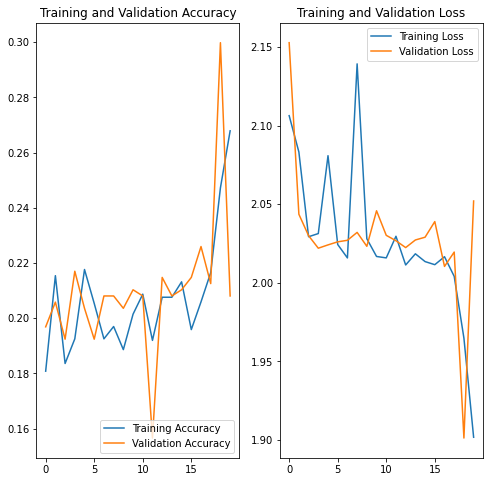

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
###### OBSERVATIONS AND FINDINGS-
- As compared to previous model, we can see that data augmentation has significantly helped in the model performance.
- We can observe that the validation loss has decreased considerably as compared to previous model.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [37]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Python Projects/Melano...,actinic keratosis
1,/content/gdrive/MyDrive/Python Projects/Melano...,actinic keratosis
2,/content/gdrive/MyDrive/Python Projects/Melano...,actinic keratosis
3,/content/gdrive/MyDrive/Python Projects/Melano...,actinic keratosis
4,/content/gdrive/MyDrive/Python Projects/Melano...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Python Projects/Melano...,vascular lesion
2235,/content/gdrive/MyDrive/Python Projects/Melano...,vascular lesion
2236,/content/gdrive/MyDrive/Python Projects/Melano...,vascular lesion
2237,/content/gdrive/MyDrive/Python Projects/Melano...,vascular lesion


In [38]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Python Projects/Melano...,actinic keratosis
1,/content/gdrive/MyDrive/Python Projects/Melano...,actinic keratosis
2,/content/gdrive/MyDrive/Python Projects/Melano...,actinic keratosis
3,/content/gdrive/MyDrive/Python Projects/Melano...,actinic keratosis
4,/content/gdrive/MyDrive/Python Projects/Melano...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Python Projects/Melano...,vascular lesion
2235,/content/gdrive/MyDrive/Python Projects/Melano...,vascular lesion
2236,/content/gdrive/MyDrive/Python Projects/Melano...,vascular lesion
2237,/content/gdrive/MyDrive/Python Projects/Melano...,vascular lesion


<BarContainer object of 9 artists>

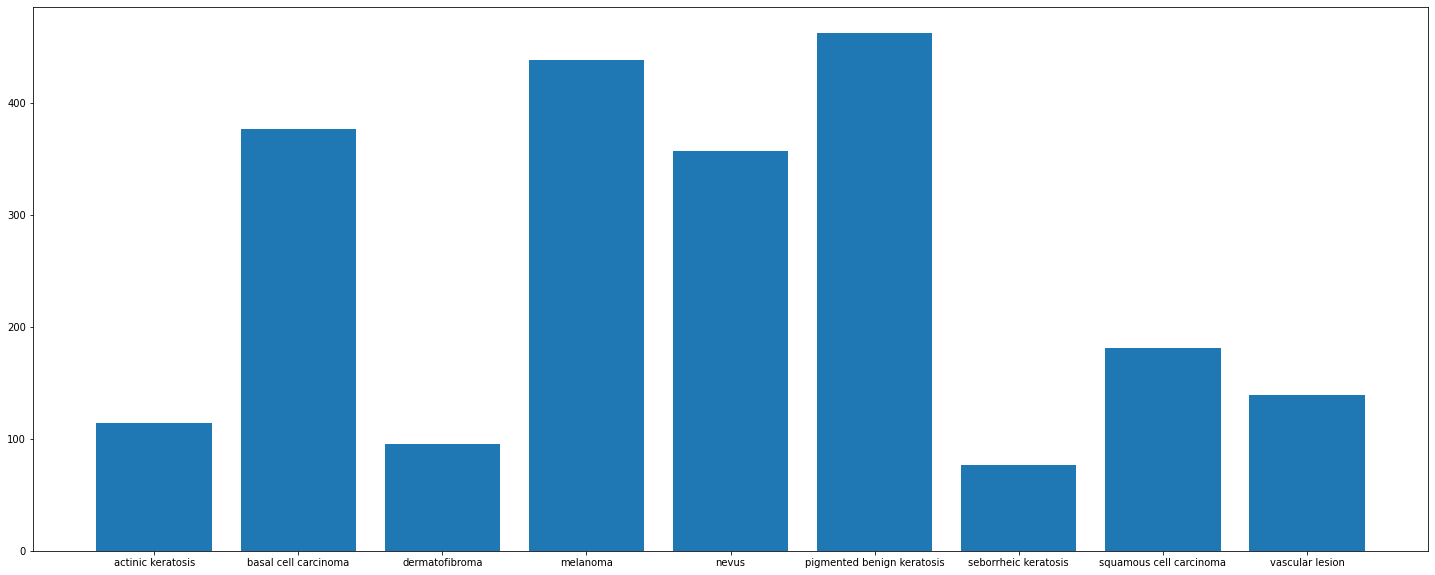

In [39]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

In [40]:
for loop in class_names:
  print(loop)

actinic keratosis
basal cell carcinoma
dermatofibroma
melanoma
nevus
pigmented benign keratosis
seborrheic keratosis
squamous cell carcinoma
vascular lesion


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?
Ans-
- 1) dermatofibroma has least number of samples,followed by seborrheic keratosis and actinic keratosis.

- 2) melanoma and pigmented benign keratosis have proprtionate number of classes.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [41]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [42]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("/content/gdrive/MyDrive/Python Projects/Melanoma Assignment/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Python Projects/Melanoma Assignment/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F58AA471D90>: 100%|██████████| 500/500 [00:55<00:00,  8.94 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Python Projects/Melanoma Assignment/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F58AA8CAAD0>: 100%|██████████| 500/500 [00:45<00:00, 11.06 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Python Projects/Melanoma Assignment/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F58AA77B2D0>: 100%|██████████| 500/500 [00:43<00:00, 11.38 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Python Projects/Melanoma Assignment/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F58AA8D4C50>: 100%|██████████| 500/500 [00:44<00:00, 11.23 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Python Projects/Melanoma Assignment/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F58BE1E6850>: 100%|██████████| 500/500 [00:46<00:00, 10.70 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Python Projects/Melanoma Assignment/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F58BE374E50>: 100%|██████████| 500/500 [00:43<00:00, 11.53 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Python Projects/Melanoma Assignment/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F58AB2FE990>: 100%|██████████| 500/500 [00:43<00:00, 11.40 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Python Projects/Melanoma Assignment/Train/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F59306BD610>: 100%|██████████| 500/500 [00:40<00:00, 12.39 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Python Projects/Melanoma Assignment/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5930048190>: 100%|██████████| 500/500 [00:41<00:00, 12.11 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [43]:
data_dir_train1 = pathlib.Path("/content/gdrive/MyDrive/Python Projects/Melanoma Assignment/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [44]:
for i in class_names:
      
    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/gdrive/MyDrive/Python Projects/Melano...,actinic keratosis
1,/content/gdrive/MyDrive/Python Projects/Melano...,actinic keratosis
2,/content/gdrive/MyDrive/Python Projects/Melano...,actinic keratosis
3,/content/gdrive/MyDrive/Python Projects/Melano...,actinic keratosis
4,/content/gdrive/MyDrive/Python Projects/Melano...,actinic keratosis
...,...,...
6734,/content/gdrive/MyDrive/Python Projects/Melano...,vascular lesion
6735,/content/gdrive/MyDrive/Python Projects/Melano...,vascular lesion
6736,/content/gdrive/MyDrive/Python Projects/Melano...,vascular lesion
6737,/content/gdrive/MyDrive/Python Projects/Melano...,vascular lesion


In [45]:
new_df['Label'].value_counts()

pigmented benign keratosis    1414
melanoma                      1319
basal cell carcinoma          1130
nevus                         1121
squamous cell carcinoma        476
vascular lesion                410
actinic keratosis              364
dermatofibroma                 281
seborrheic keratosis           224
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [46]:
batch_size = 32
img_height = 180
img_width = 180

In [59]:
import pathlib
data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/Python Projects/Melanoma Assignment/Train/output")

In [60]:
data_dir_train1

PosixPath('/content/gdrive/MyDrive/Python Projects/Melanoma Assignment/Train/output')

#### **Todo:** Create a training dataset

In [61]:
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


In [62]:
data_dir_train="/content/gdrive/MyDrive/Python Projects/Melanoma Assignment/Train/output"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [63]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [64]:
## your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.35))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [65]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [66]:
epochs =50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


113/113 [==============================] - 21s 171ms/step - loss: 2.0226 - accuracy: 0.2039 - val_loss: 1.9316 - val_accuracy: 0.2589
Epoch 2/50
113/113 [==============================] - 20s 169ms/step - loss: 1.8368 - accuracy: 0.3111 - val_loss: 1.7447 - val_accuracy: 0.3378
Epoch 3/50
113/113 [==============================] - 20s 168ms/step - loss: 1.6200 - accuracy: 0.4186 - val_loss: 1.5171 - val_accuracy: 0.4489
Epoch 4/50
113/113 [==============================] - 20s 171ms/step - loss: 1.4712 - accuracy: 0.4747 - val_loss: 1.4049 - val_accuracy: 0.5000
Epoch 5/50
113/113 [==============================] - 20s 168ms/step - loss: 1.3904 - accuracy: 0.5117 - val_loss: 1.2845 - val_accuracy: 0.5500
Epoch 6/50
113/113 [==============================] - 20s 168ms/step - loss: 1.3700 - accuracy: 0.5147 - val_loss: 1.2872 - val_accuracy: 0.5356
Epoch 7/50
113/113 [==============================] - 20s 166ms/step - loss: 1.2878 - accuracy: 0.5381 - val_loss: 1.3170 - val_accuracy: 0.5

#### **Todo:**  Visualize the model results

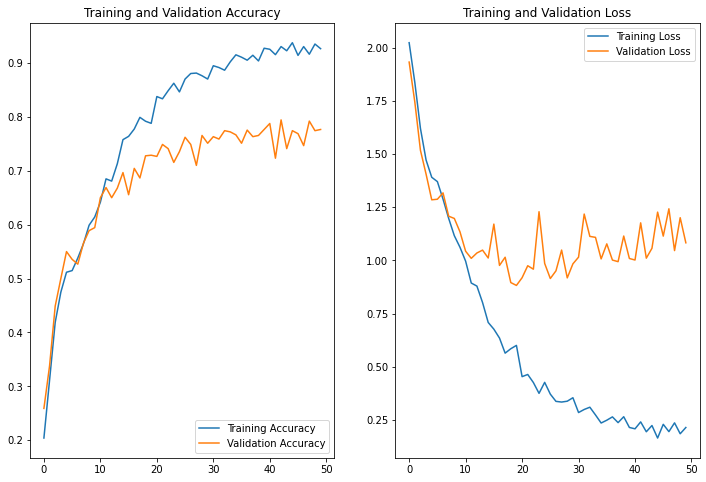

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- Accuracy on training data has increased by using Augmentor library

- Model is still overfitting as error has increased after 20 epochs.

- The Model can be further  by tuning the hyperparameters.

- The problem of overfitting can be solved by adding more layers,neurons or adding dropout layers.

